## GSD 


In [29]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import utils
from snsynth import Synthesizer
from snsynth.gsd import GSDSynthesizer
import time

from load_data import load_data
from sklearn.model_selection import train_test_split



In [32]:
adult_path = 'adult.csv'
datasets = load_data(['adult'])
    
adult_df = datasets['adult']['data']

target =  datasets['adult']['target']
categorical_columns =  datasets['adult']['categorical_columns'].split(',')
print(adult_df.columns)
print(categorical_columns)


# Create config file. Note that we know the lower bound of each ordinal feature is 0.
ordinal_columns = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'fnlwgt']
continuous_columns = []
config = {}
for c in adult_df.columns:
    if c in categorical_columns:
        config[c] = {'type': 'string'}
    else:
        config[c] = {'type': 'int', 'lower': 0}


# Split into train/test sets for machine learning evaluation.
adult_df_train, adult_df_test = train_test_split(adult_df, test_size=0.2)

loading downloaded_datasets/adult.csv
Memory consumed by adult:4167808
Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'earning-class'],
      dtype='object')
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'earning-class']


# Adult

In [6]:
# Still need to implement 
synth = GSDSynthesizer(1.0, 1e-5, verbose=True)
synth.fit(adult_df_train,  meta_data=config,
          N_prime=5000,
          preprocessor_eps=0.1)

max_error = np.abs(synth.stat_fn(synth.data.to_numpy()) - synth.stat_fn(synth.sync_data.to_numpy())).max()
print(f'Statistical error:', max_error)

Spent 0.09999999999999999 epsilon on preprocessor, leaving 0.9 for training
privacy budgets: First moments = 0.001652. Second moments = 0.028905
Cond.Marginal= ['age'] . Sigma=0.0069. Top.Level=7. Max.Size=None
Cond.Marginal= ['fnlwgt'] . Sigma=0.0083. Top.Level=10. Max.Size=None
Cond.Marginal= ['education-num'] . Sigma=0.0052. Top.Level=4. Max.Size=None
Cond.Marginal= ['capital-gain'] . Sigma=0.0037. Top.Level=2. Max.Size=None
Cond.Marginal= ['capital-loss'] . Sigma=0.0083. Top.Level=10. Max.Size=None
Cond.Marginal= ['hours-per-week'] . Sigma=0.0064. Top.Level=6. Max.Size=None
	Total size=4508
       age.tree_height = 5. Thresholds=49
    fnlwgt.tree_height = 6. Thresholds=70
education-num.tree_height = 3. Thresholds=14
capital-gain.tree_height = 1. Thresholds=3
capital-loss.tree_height = 2. Thresholds=4
hours-per-week.tree_height = 4. Thresholds=25
Cond.Marginal= ['age', 'fnlwgt'] . Sigma=0.0064. Top.Level=6. Max.Size=None
Cond.Marginal= ['age', 'education-num'] . Sigma=0.0059. Top.L

In [ ]:
adult_sync_df = synth.sample()
adult_sync_df.to_csv('downloaded_datasets/adult_sync_1.csv')
print(adult_sync_df)

adult_sync_df['Type'] = 'Sync'
adult_df_copy = adult_df.sample(n=5000).copy()
adult_df_copy['Type'] = 'Real'

df = pd.concat([adult_sync_df, adult_df_copy])

"""
Plot subgroups distributions:
"""
g = sns.FacetGrid(data=df, col='Type',  hue='earning-class', sharey=False)
g.map(sns.histplot, 'capital-gain')
g.add_legend()
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import RidgeClassifier



Trained on Real Data
              precision    recall  f1-score   support

           0       0.82      0.96      0.89      4942
           1       0.74      0.33      0.46      1571

    accuracy                           0.81      6513
   macro avg       0.78      0.65      0.67      6513
weighted avg       0.80      0.81      0.78      6513

Accuracy real: 0.8102257024412713

Trained on Synthetic Data
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4942
           1       0.63      0.46      0.53      1571

    accuracy                           0.80      6513
   macro avg       0.74      0.69      0.70      6513
weighted avg       0.79      0.80      0.79      6513

Accuracy synthetic: 0.8042376784891755

Random Guessing
              precision    recall  f1-score   support

           0       0.78      0.51      0.62       759
           1       0.26      0.54      0.35       241

    accuracy                           0.52

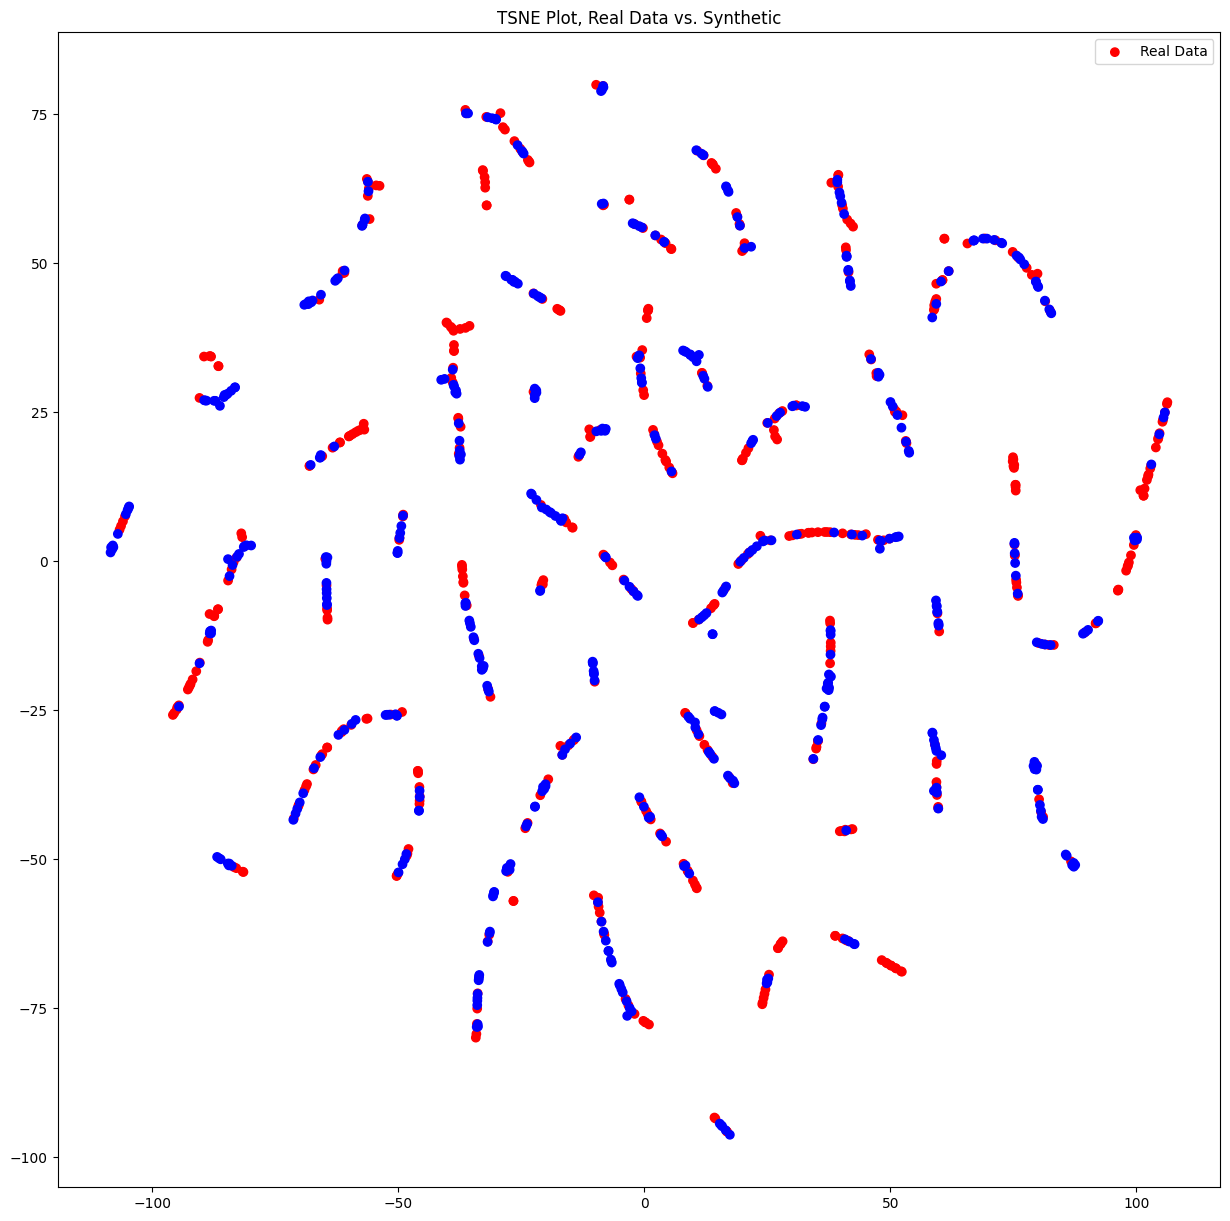

                age     workclass        fnlwgt     education  education-num  \
count  32561.000000  32561.000000  3.256100e+04  32561.000000   32561.000000   
mean      38.581647      3.868892  1.897784e+05     10.298210      10.080679   
std       13.640433      1.455960  1.055500e+05      3.870264       2.572720   
min       17.000000      0.000000  1.228500e+04      0.000000       1.000000   
25%       28.000000      4.000000  1.178270e+05      9.000000       9.000000   
50%       37.000000      4.000000  1.783560e+05     11.000000      10.000000   
75%       48.000000      4.000000  2.370510e+05     12.000000      12.000000   
max       90.000000      8.000000  1.484705e+06     15.000000      16.000000   

       marital-status    occupation  relationship          race           sex  \
count    32561.000000  32561.000000  32561.000000  32561.000000  32561.000000   
mean         2.611836      6.572740      1.446362      3.665858      0.669205   
std          1.506222      4.228857 

(RidgeClassifier(), RidgeClassifier())

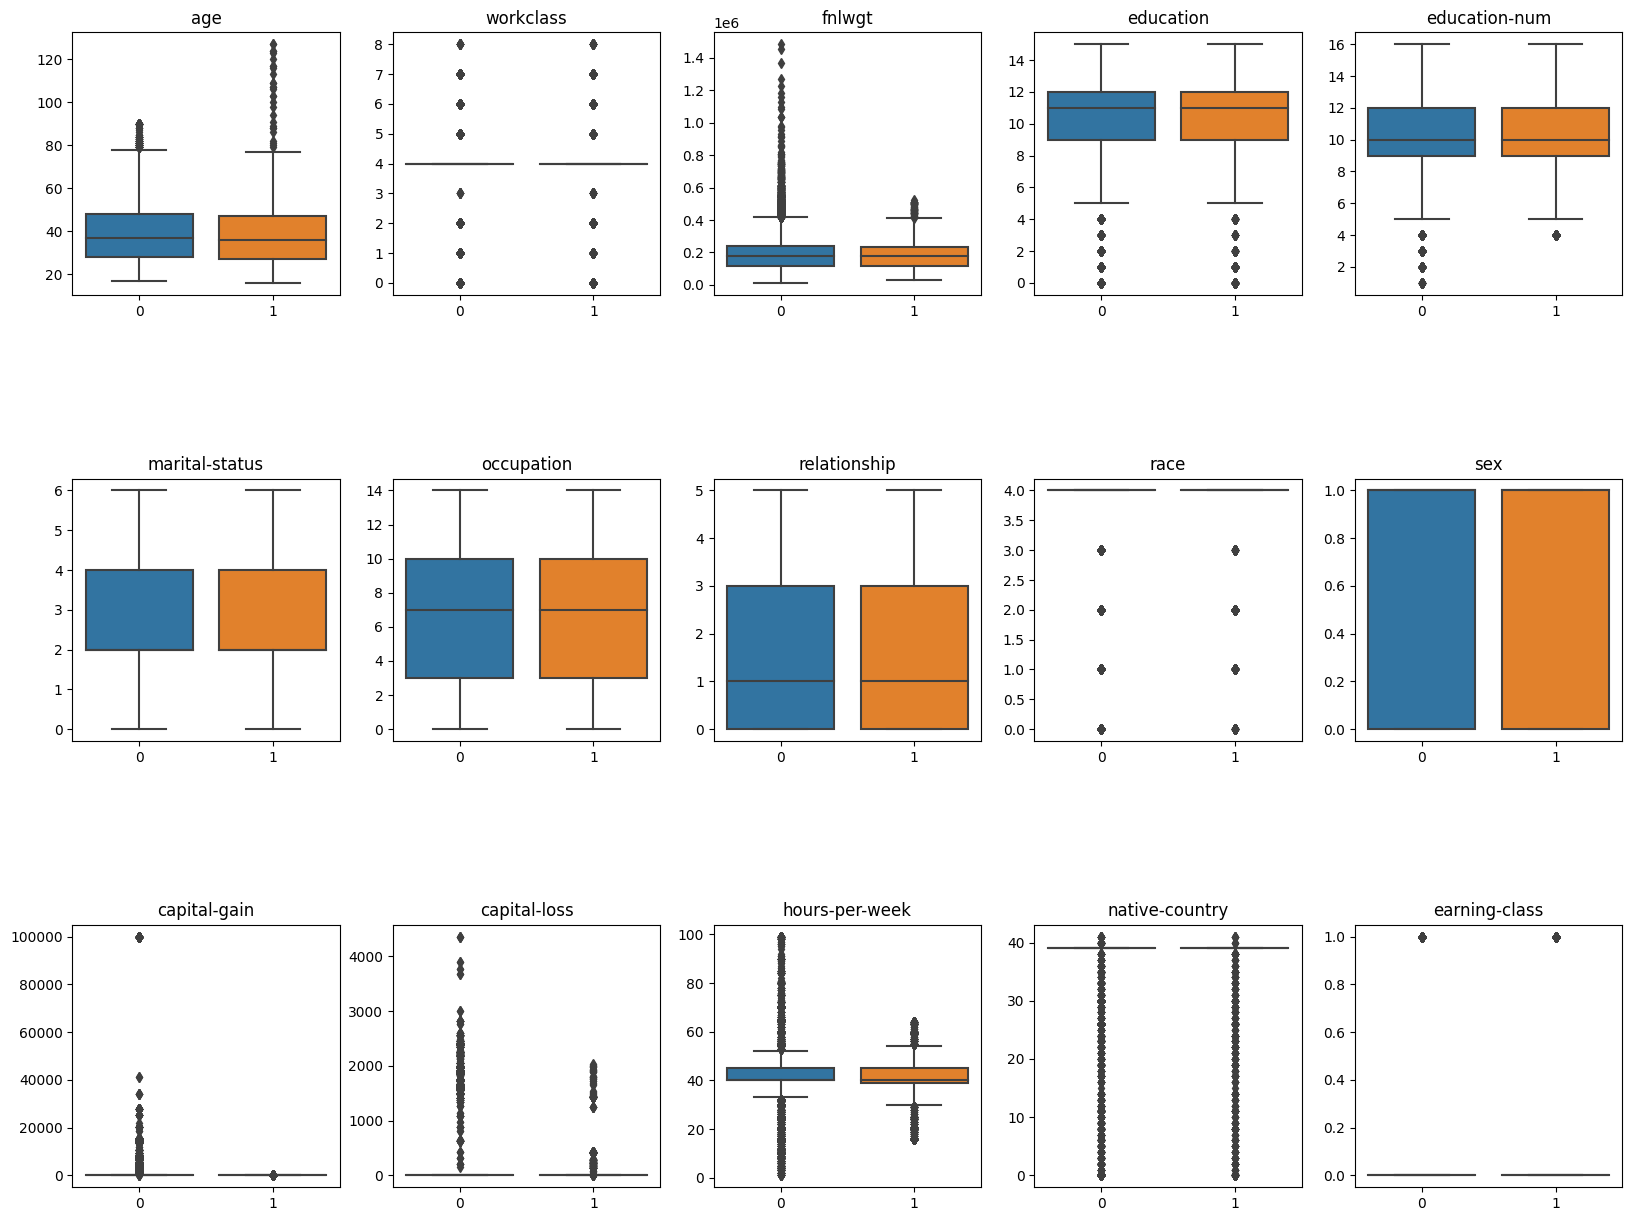

In [14]:
utils.test_real_vs_synthetic_data(adult_df, adult_sync_df, RidgeClassifier, tsne=True, box=True, describe=True)


Trained on Real Data
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      4942
           1       0.63      0.25      0.36      1571

    accuracy                           0.78      6513
   macro avg       0.72      0.60      0.62      6513
weighted avg       0.76      0.78      0.75      6513

Accuracy real: 0.7839705204974666

Trained on Synthetic Data
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      4942
           1       0.51      0.37      0.43      1571

    accuracy                           0.76      6513
   macro avg       0.66      0.63      0.64      6513
weighted avg       0.74      0.76      0.75      6513

Accuracy synthetic: 0.7620144326731153

Random Guessing
              precision    recall  f1-score   support

           0       0.77      0.51      0.61       759
           1       0.26      0.53      0.35       241

    accuracy                           0.52

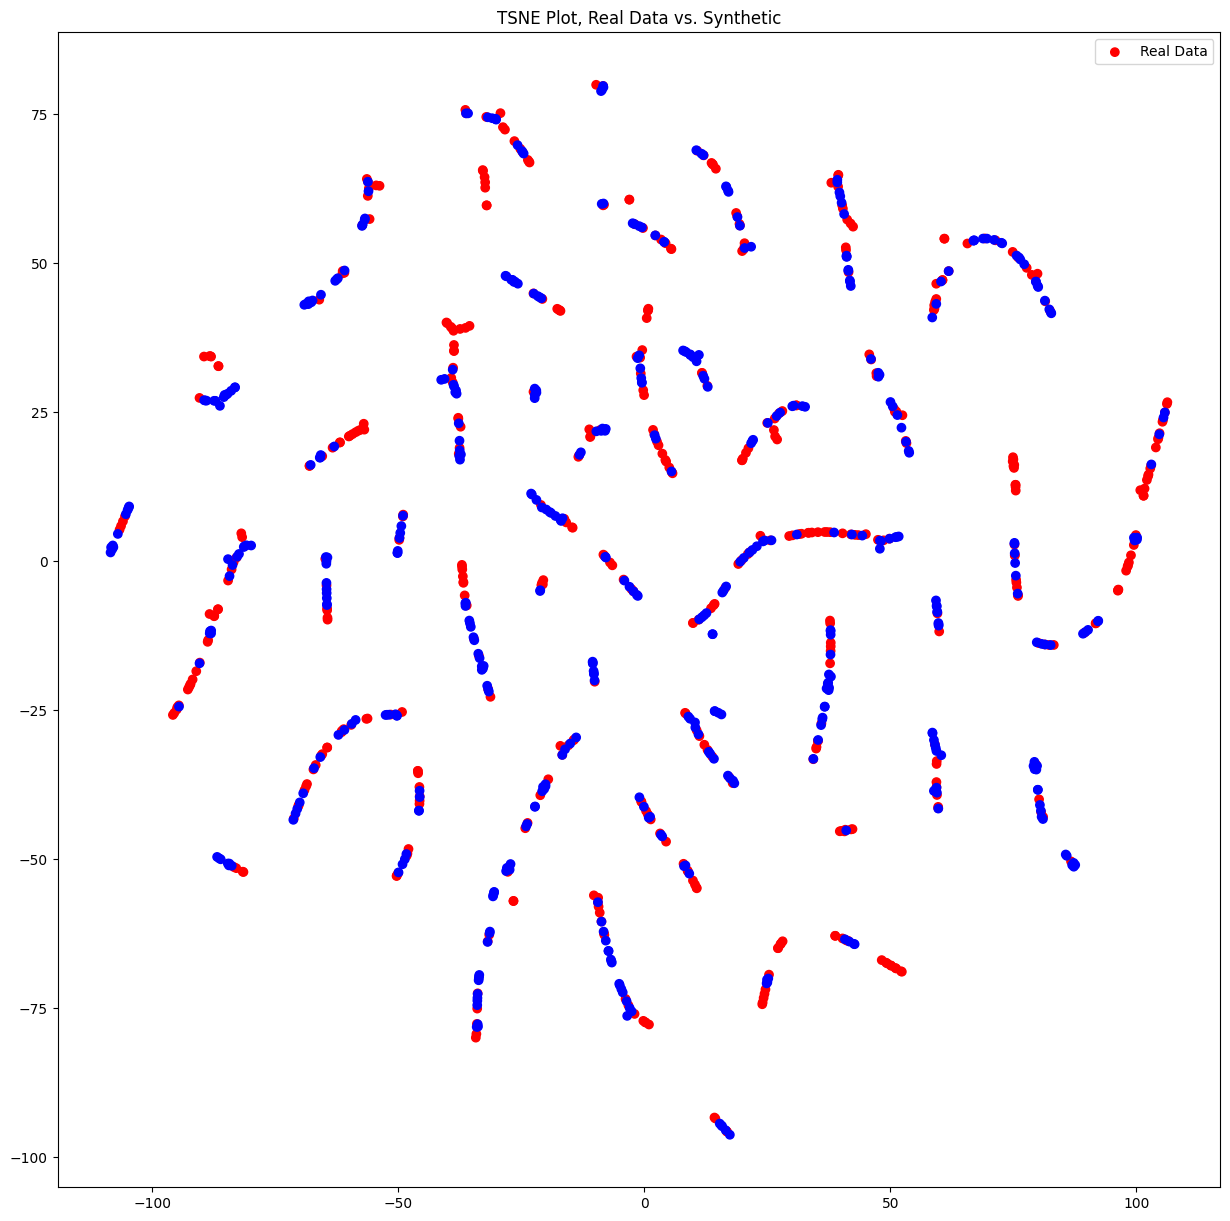

                age     workclass        fnlwgt     education  education-num  \
count  32561.000000  32561.000000  3.256100e+04  32561.000000   32561.000000   
mean      38.581647      3.868892  1.897784e+05     10.298210      10.080679   
std       13.640433      1.455960  1.055500e+05      3.870264       2.572720   
min       17.000000      0.000000  1.228500e+04      0.000000       1.000000   
25%       28.000000      4.000000  1.178270e+05      9.000000       9.000000   
50%       37.000000      4.000000  1.783560e+05     11.000000      10.000000   
75%       48.000000      4.000000  2.370510e+05     12.000000      12.000000   
max       90.000000      8.000000  1.484705e+06     15.000000      16.000000   

       marital-status    occupation  relationship          race           sex  \
count    32561.000000  32561.000000  32561.000000  32561.000000  32561.000000   
mean         2.611836      6.572740      1.446362      3.665858      0.669205   
std          1.506222      4.228857 

(ComplementNB(), ComplementNB())

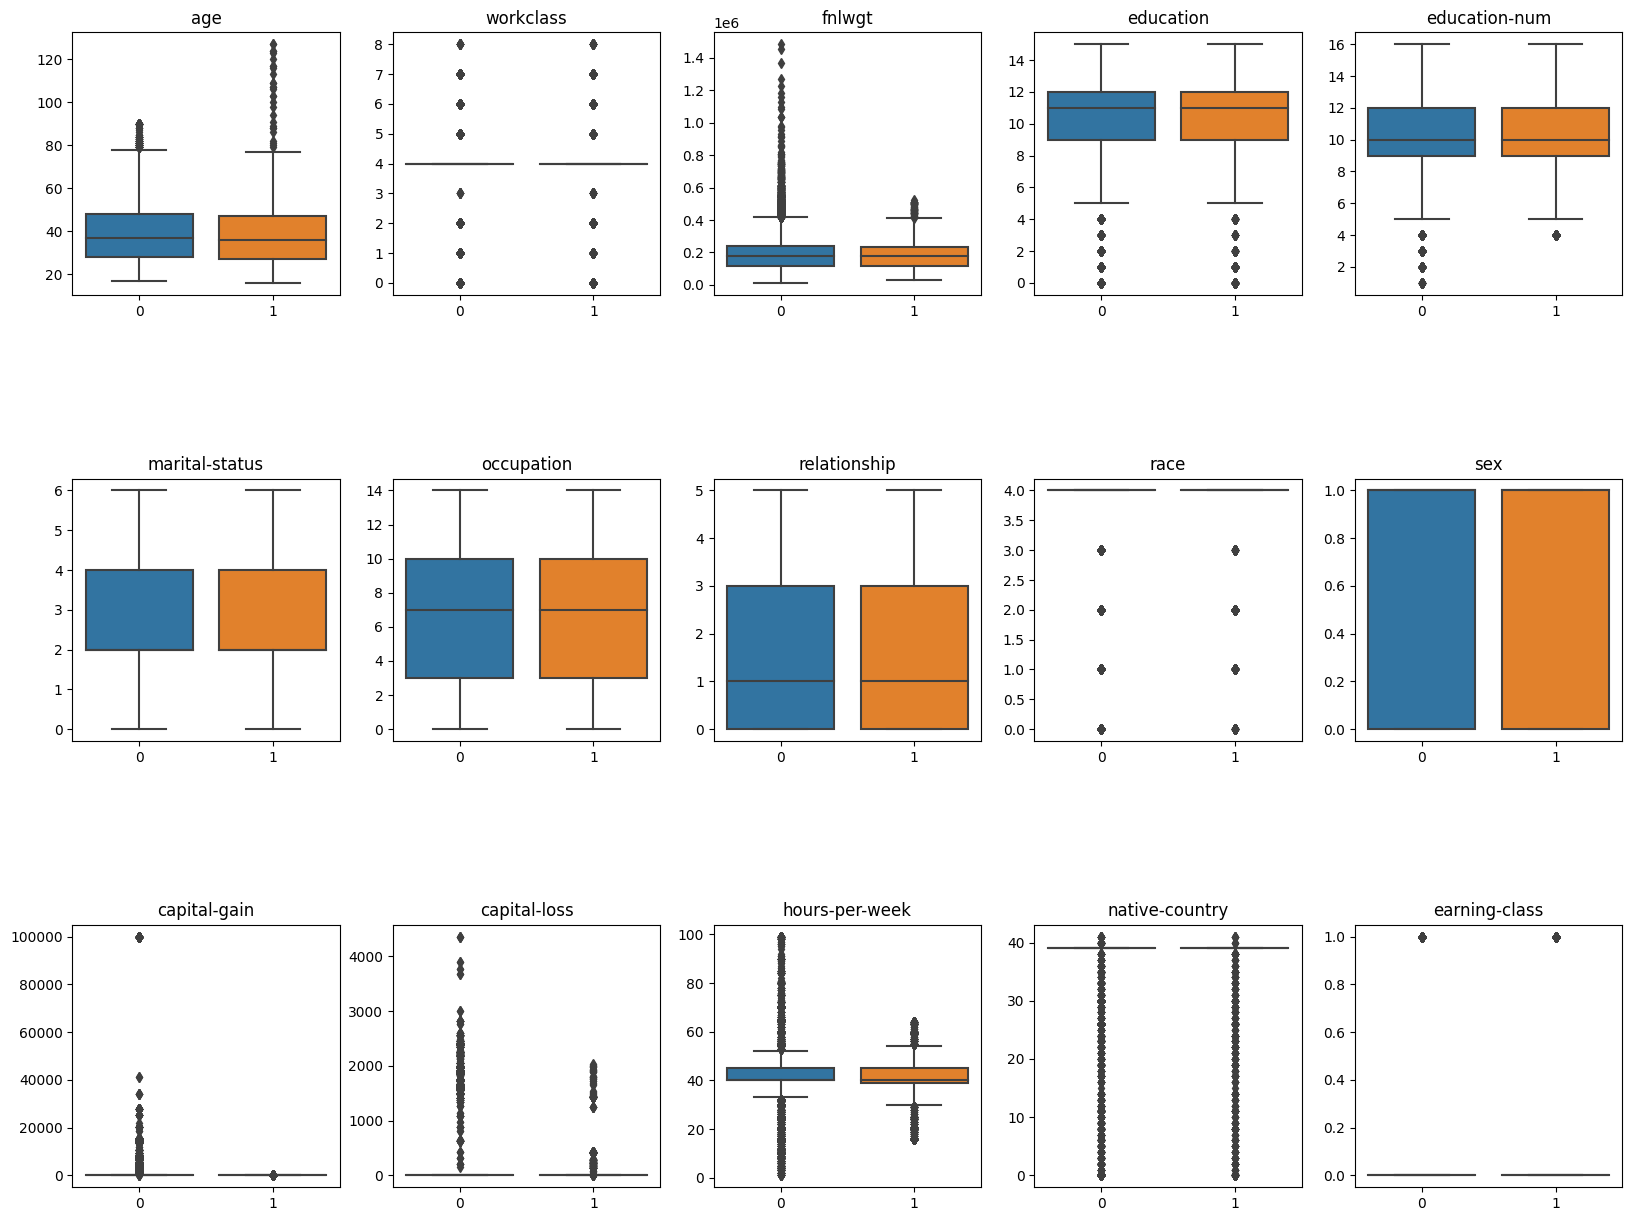

In [15]:
utils.test_real_vs_synthetic_data(adult_df, adult_sync_df, ComplementNB, tsne=True, box=True, describe=True)

In [ ]:
utils.test_real_vs_synthetic_data(adult_df, adult_sync_df, ComplementNB, tsne=True, box=True, describe=True)

# End